Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2$.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

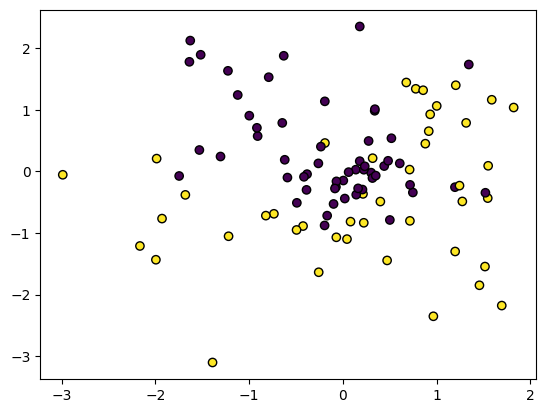

In [2]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [3]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [4]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [5]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    assert Phi.shape[1] == w.shape[0], f"Epexcted dim1(Phi) = dim0(w), got shape Phi = {Phi.shape} and shape w = {w.shape}"

    mu = predict_probs_MAP(Phi, w)

    likelihood = dist.Bernoulli(mu).log_prob(y).sum(0)

    prior = dist.MultivariateNormal(loc=torch.zeros(Phi.shape[1]), covariance_matrix=(sigma**2)*torch.eye(Phi.shape[1])).log_prob(w).sum(0)

    return likelihood + prior

In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [8]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    
    losses = []
    
    # Defining an optimiser
    opt = torch.optim.Adagrad((weights, ), lr=0.1)

    # iterate
    i_step = 0
    N_steps = 10000

    # convergence
    converged = False

    while (converged == False):
        # zero the gradients
        opt.zero_grad()
        # forward pass
        loss = -log_joint(Phi, y, weights)
        # backward pass
        loss.backward()
        # save value for reference (`.item()` returns the raw scalar!) (weights.item(), y.item()
        losses.append(loss.item())
        # do one optmizer step
        opt.step()
        # check convergence 
        if i_step > 0:
                dif = abs(losses[i_step] - losses[i_step-1])
                if dif < 0.001:
                        converged = True

        if i_step > N_steps : break
        else: i_step += 1
        
    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

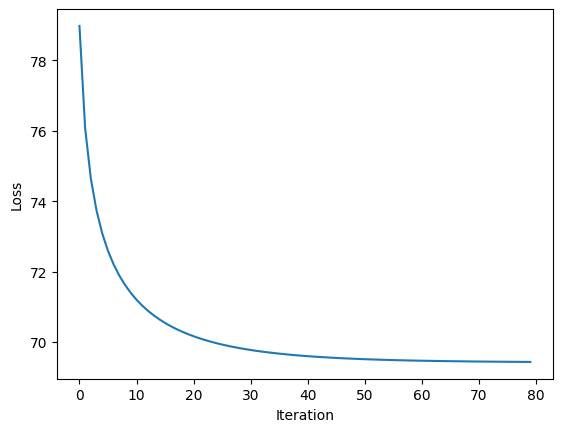

In [9]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

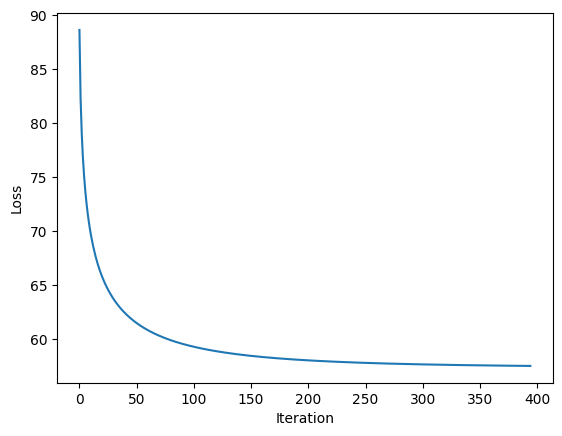

In [10]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [11]:
# (GRADING)

In [12]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [13]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


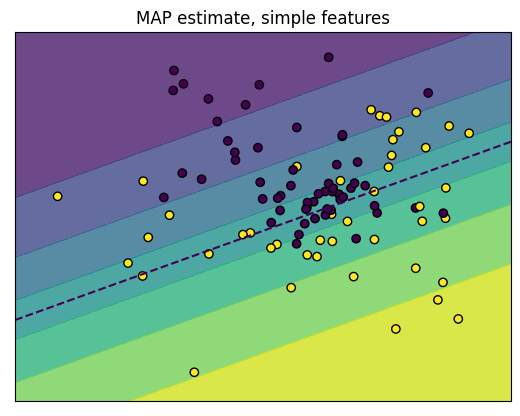

In [14]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.90


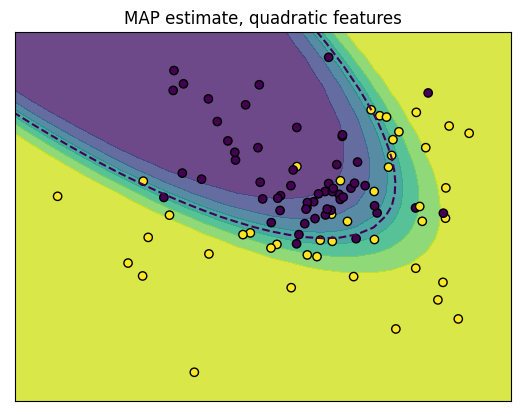

In [15]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [16]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """

    assert Phi.shape[1] == w_MAP.shape[0], f"Epexcted dim1(Phi) = dim0(w), got shape Phi = {Phi.shape} and shape w = {w_MAP.shape}"

    # Get Inverse S_0
    inverse_S_0 = (1 / prior_std**2) * torch.eye(Phi.shape[1])

    # Get Observation Term
    y_pred = predict_probs_MAP(Phi, w_MAP)
    y_pred_survival = 1 - y_pred
    B_diag = (y_pred * (1 - y_pred)) * torch.eye(len(y_pred))

    # Hessian
    hessian = inverse_S_0 + Phi.transpose(0,1) @ B_diag @ Phi

    # Covariance
    Cov = torch.inverse(hessian)
    
    return Cov    

In [17]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    # Number of samples
    L = 10000

    # Laplace Approximate posterior
    laplac_approximate_posterior = dist.MultivariateNormal(loc = w_MAP, covariance_matrix = Cov)

    # L samples of weights from laplace posterior
    posterior_sample_weights = laplac_approximate_posterior.sample(sample_shape=(L,))

    # Monte carlo estimate for each row in phi in Phi
    monte_carlo_estimates = torch.tensor([(1/L)*torch.sum(torch.sigmoid(posterior_sample_weights @ phi)) for phi in Phi])

    return monte_carlo_estimates

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [18]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

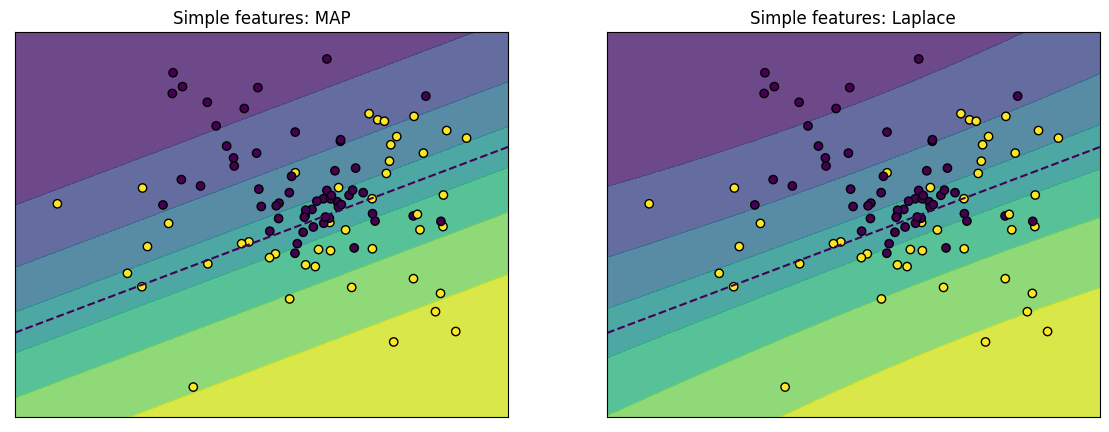

In [19]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [20]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

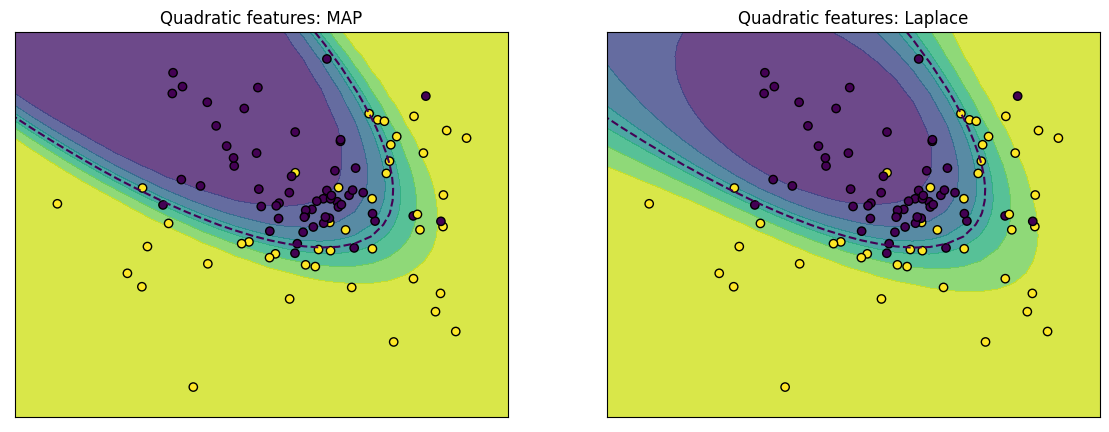

In [21]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [22]:
# (GRADING)

In [23]:
# (GRADING)

In [24]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [25]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    
    assert Phi.shape[1] == w_MAP.shape[0], f"Epexcted dim1(Phi) = dim0(w), got shape Phi = {Phi.shape} and shape w = {w_MAP.shape}"

    # log(p(y|w_MAP)) + log(p(w_MAP))
    posterior_map = log_joint(Phi, y, w_MAP)

    # Occam Factor (p(w_MAP) included in log_joint)
    occam_factor = (Phi.shape[1]/2)*torch.log(2*torch.tensor(torch.pi)) - (1/2)*torch.log(torch.det(torch.inverse(Cov)))
    
    log_evidence = posterior_map + occam_factor

    return log_evidence

In [26]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.98029327392578
Model evidence estimate (polynomial features): -57.96349334716797


In [27]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [28]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    
    assert X.shape[1] == 2, f'X epected dimension 2, but got: {X.shape[1]}'

    # Bases Features
    Xm_1 = torch.zeros(size=(X.shape[0], X.shape[1] + 1))
    Xm_1[:,0] = 1.0
    Xm_1[:,1:3] = X
    
    # Radial Basis - Fixed point (1,1)
    X_2 = torch.tensor([torch.sqrt(0.5 + 1*torch.norm(X[i]-torch.tensor([1,1]))**2) for i in range(len(X))]).reshape((len(X),1))

    # Radial Basis - Fixed point (0,0)
    X_4 = torch.tensor([torch.norm(X[i]-torch.tensor([0,0])) for i in range(len(X))]).reshape((len(X),1))
    
    # Final Feature Set
    Xm = torch.hstack([Xm_1, X_2, X_4]) 
    
    return Xm

    
    

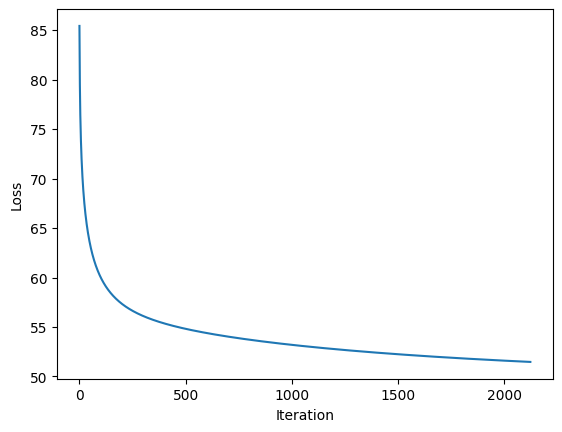

In [29]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [30]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.87, test accuracy = 0.92


In [31]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -50.28562545776367


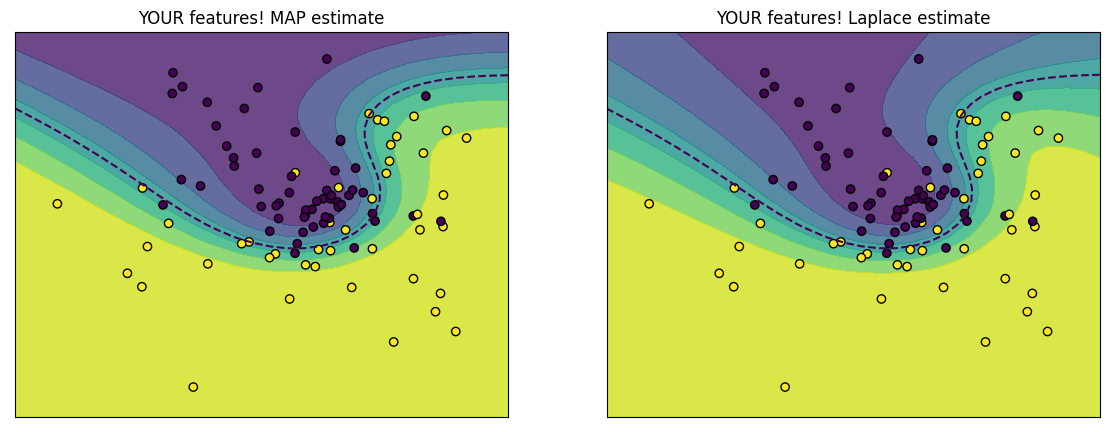

In [32]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

YOUR ANSWER HERE

**QUESTION 1:**

My feature selection process was largely based on directed trial and error. Specifically, I kept a bias term $x_0 = 1$, $x_1$ and $x_2$ but decided to experiement with Radial Basis Functions. That is, a function who's value depends on the distance between the input and some fixed point. More precisely, my expanded basis consited of 2 additional features. The euclidean distance from the point $(1,1)$ and the distance from the point $(0,0)$. The rational for including these features was due to the cluster of points in the far right corner of the space and very few mixed points in the lower half of the space. Therefore, I believed including a notion of distance from these fixed points (caputured by the quadratic radial basis function) would improve my predictions. As such, after experimentation my chosen features increased the test set accuracy to 92%, training accuracy to 87% and increased the model evidence to approximatley -50.

The most straightforward and chaste method of comparing feature sets is to compare the performances of identical models, trained on each different feature set. That is, select the feature set that yields the models with the best performance metrics. For example, lower test set error, and higher test set classification accuracy. As doing so implies that the additional feature increases the predictive power of our model beyond the other set(s). A more robust way of achieving this would be to use K-fold cross validation to ensure that the increase in model performance isn't down Aleatoric uncertainty. 

A second approach unique to Bayesian treatments of linear models is to compare the model evidences of two identical models trained on the difference feature sets. That is comparing $p(D |M_1)$ v.s. $p(D | M_2)$ where $M_1$ denotes the model trained on one feature space and $M_2$ denotes the same model trained on the alternative feature space. Specifically, the model evidence expresses the preference shown by the data for different models. This framework has the added benefit of penalising overcomplicated models and can help guard against the problem of overfitting. In such a framework we could pick the model with the highest model evidence. 

As a result, it should be clear that these two frameworks will not always produce the same ranking of different features. More precisely, focusing primarily on test loss and test accuracy can quickly lead to overfitting, whereby our model begins to fit the aleatoric noise in the data. However, comparing the model evidence would penalise such an overcomplicated model and may favor a different set of features with marginally lower predictive power but is far simpler. (Ref. to Occam's Razor) However, generally speaking we would expect better models to achieve better predictive accuracy by fitting the general trend of the data better and as such also be favored by the model evidence.

To conlcude one should not focus specifically on one way or another to choose a feature set but should consider multiple methods as part of a larger analysis.

**QUESTION 2:**

No, I do not believe that overfitting is possible in a Bayesian setting. This is because when using Bayes theorem we are implicitly assuming a conditional dependence on the selected model where we observe that the normalising constant is precisely the model evidence. That is:

$$ p(\bold{w} | D, M) = \frac{p(D | \bold{w}, M) p(\bold{w}, M)}{p(D|M)}$$

The normalising constant/model evidence can be approximated by assuming that the posterior is sharply concentrated around its $w_{map}$ estimate as would be the case in over-fitting. In this case, the area of the likelihood can be approximated by the width of the posterior ($\Delta_{w_{\text{posterior}}}$) multiplied by the value of it's density. Further, assuming that the prior is flat with width $\Delta_{w_{\text{prior}}}$. i.e $p(\bold{w}, M) = \frac{1}{\Delta_{w_{\text{prior}}}}$ then the model evidence can be approximated as such:

$$p(D|M) = \int p(D| \bold{w}, M) p(\bold{w}, M) \approx p(D|\bold{w_{MAP}}) \frac{\Delta_{w_{\text{posterior}}}}{\Delta_{w_{\text{prior}}}}$$

Or equivalently

$$\log(p(D|M)) \approx \log(p(D|\bold{w_{MAP}})) + \log(\frac{\Delta_{w_{\text{posterior}}}}{\Delta_{w_{\text{prior}}}})$$

Therefore, as $\frac{\Delta_{w_{\text{posterior}}}}{\Delta_{w_{\text{prior}}}} \rightarrow 0$, $\log(\frac{\Delta_{w_{\text{posterior}}}}{\Delta_{w_{\text{prior}}}}) \rightarrow \infty$ That is to say if the parameters are finely tuned to the data as is the case in overfitting, then the penalty term becomes very large. Furthermore, it can be shown the that magnitude of the complexity term increases linearly with the number of parameters in the model [*Bishop*]. As a result, as the number of parameters increases the model complexity, the first term will increase as we fit the data better but the second term will compensate by penalising for the added complexity. Ultimatley, Bayesian methods have an in-built regularization method from which the optimal model complexity is determined by the maximum evidence.

That said, since the model evidence is complicated to compute, we typically ommit it and use the fact that the posterior is proporitional to the likelihood $\times$ prior. Consequently, as the number of data points inceases and the effect of the prior decreases we are liable to overfitting as we converge to the MLE estimate. As a result, in these cases, although the Laplace approximationg does not stricly help with overfitting it does provide us with a model evidence that we can readily compute and evaluate to see the effect of the model complexity. However, note that since the laplace approximation relies on $w_{\text{MAP}}$ and as such does not prevent overfitting during the training process such as a traditional regularization technique but provides us with a quantitative value from which we can evaluate the risk that our model has overfit **post** training. Furthere note that the approximation in-itself does not help reduce overfitting significantly as if the posterior is densly concentrated around the MAP, a Gaussian will also be densly concentrated around the MAP.

Fortunatley, I did not experience overfitting as my feature space did not get overly complicated. The easiest way to diagnose overfitting is to compare training and test performance statistics. Typically, overfitting is characterised by very high training accuracy and very low training loss, but very low test accuracy and very high test loss as our model struggles to generalise as it is too tunned to the training data (learning the training data noise). Visually, we can also diagnose overfitting as a decision boundary that is capturing the noise in the data in addtition to the general trend. 

Reference: *Pattern Recognition and Machine Learning - Bishop, Chapter 3 - Linear Models for Regression*

#### Ignore the following cells. They are used by the grading system.

In [33]:
# (GRADING)

In [34]:
# (GRADING)